In [54]:
import pandas as pd
import numpy as np

import pmdarima as pm

from statsmodels import api as sm

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import STL


#### 1.0. This exercise uses data set LakeHuron giving the level of Lake Huron from 1875–1972.

##### a) Convert the data to a tsibble object using the as_tsibble() function. 

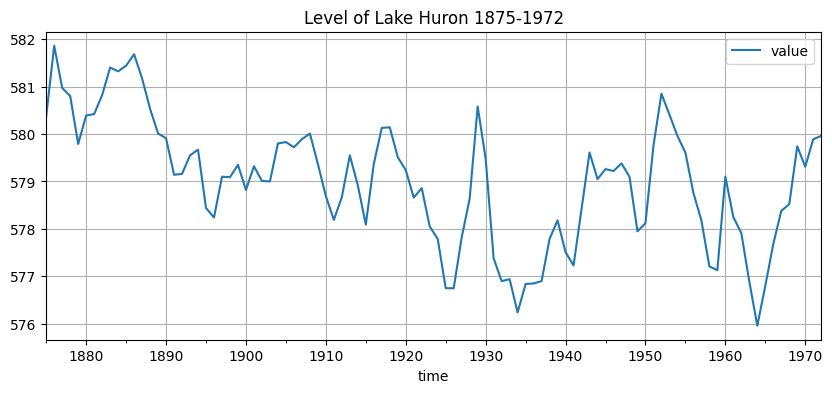

In [85]:
df = pd.read_csv("../data/LakeHuron.csv").iloc[:, 1:]

df["time"] = pd.to_datetime(df["time"], format="%Y")

df.plot(x="time", figsize=(10, 4), grid=2, title="Level of Lake Huron 1875-1972");

##### b) Fit a piecewise linear trend model to the Lake Huron data with a knot at 1920 and an ARMA error structure.

In [86]:
df["trend"] = df["value"].rolling(window=10).mean()

df.dropna(inplace=True)

In [87]:
a = sm.OLS(
    df["value"],
    df["trend"]
).fit()

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.908e+07
Date:                Wed, 27 Dec 2023   Prob (F-statistic):                   1.23e-244
Time:                        14:11:17   Log-Likelihood:                         -126.90
No. Observations:                  89   AIC:                                      255.8
Df Residuals:                      88   BIC:                                      258.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.9999      0.000   5392.226      0.000       0.999       1.000
==============================================================================
Omnibus:                        3.073   Durbin-Watson:                   0.485
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                1.892
Skew:                           0.099   Prob(JB):                        0.388
Kurtosis:                       2.313   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

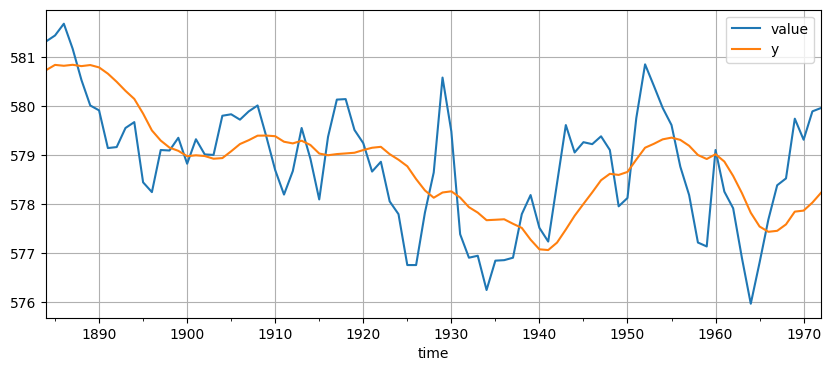

In [89]:
df["y"] = a.predict(df["trend"])

ax = df.plot(x="time", y="value", figsize=(10, 4))
ax = df.plot(x="time", y="y", grid=2, ax=ax)

In [90]:
am = pm.auto_arima(
    y=df["trend"]
)

am.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  81.661
Date:                Wed, 27 Dec 2023   AIC                           -157.323
Time:                        14:12:04   BIC                           -149.891
Sample:                             0   HQIC                          -154.329
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6532      0.109      5.995      0.000       0.440       0.867
ma.L1          0.3405      0.123      2.778      0.005       0.100       0.581
sigma2         0.0090      0.002      5.791      0.000       0.006       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.95   Prob(JB):                         0.79
Heteroskedasticity (H):               2.24   Skew:                            -0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### c) Forecast the level for the next 30 years. Do you think the extrapolated linear trend is realistic?

In [ ]:
level = a.predict(am.predict(30).values)

dff = pd.DataFrame({"value": level, "time": [i for i in range(df.time.dt.year.max() + 1, df.time.dt.year.max() + 31)]})
dff["time"] = pd.to_datetime(dff["time"], format="%Y")

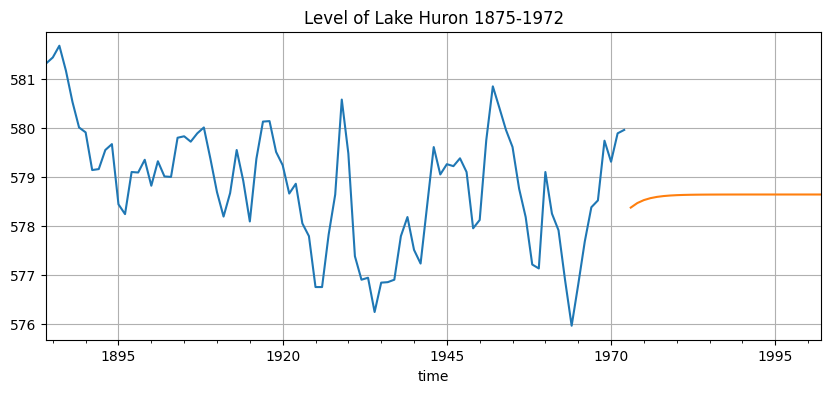

In [116]:
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(x="time", y="value", ax=ax, legend=None)
dff.plot(x="time", ax=ax, legend=None)
ax.set_title("Level of Lake Huron 1875-1972")
ax.grid(2)

#### 2.0. Repeat Exercise 4 from Section 7.10, but this time adding in ARIMA errors to address the autocorrelations in the residuals.

In [6]:
df = pd.read_csv("../data/souvenirs.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

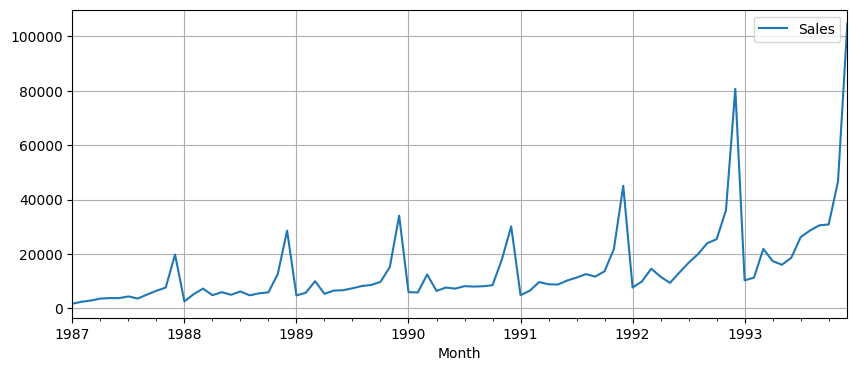

In [10]:
df.plot(x="Month", grid=2, figsize=(10, 4));

In [17]:
df["LogSales"] = np.log1p(df["Sales"])

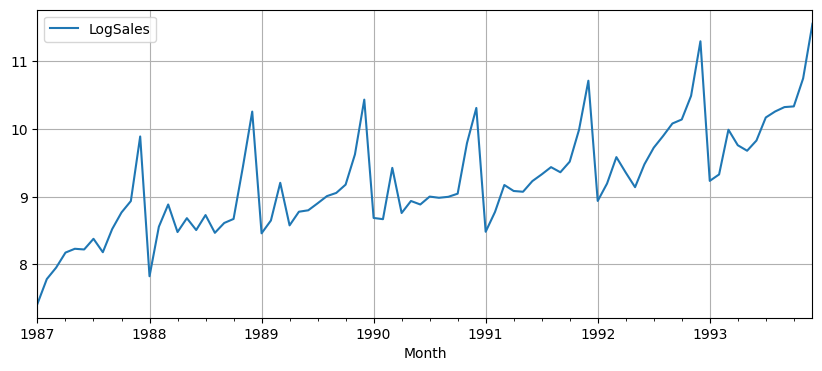

In [18]:
df.plot(x="Month", y="LogSales", grid=2, figsize=(10, 4));

##### a) How much difference does the ARIMA error process make to the regression coefficients?


Do not exists a independent variable to fit dynamic regression, i can use month index or any dummy date index, but the exercice question is not cleary. but i can use a fourier series too.

In [24]:
df.head()

,Month,Sales,LogSales,MonthIdx
1,1987-01-01,1664.81,7.418067,1
2,1987-02-01,2397.53,7.782611,2
3,1987-03-01,2840.71,7.952161,3
4,1987-04-01,3547.29,8.174221,4
5,1987-05-01,3752.96,8.230567,5


##### b) How much difference does the ARIMA error process make to the forecasts?



In [26]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Month.max(),
        end=df.Month.max() + pd.offsets.DateOffset(years=2),
        freq="MS"    
    )[1:]
).rename(columns={0:"Month"})

In [33]:
u = sm.tsa.UnobservedComponents(
    endog=df["LogSales"].to_numpy(),
    level=True,
    trend=True,
    freq_seasonal=[
        {"period": 12,
         "harmonics": 6}
    ]
).fit(disp=0)

f = u.get_forecast(steps=len(forecast))
fs, confs = f.predicted_mean, f.conf_int(alpha=0.05)

forecast["LogSales"] = f.predicted_mean
forecast["lower"], forecast["upper"] = confs[:, 0], confs[:, 1]

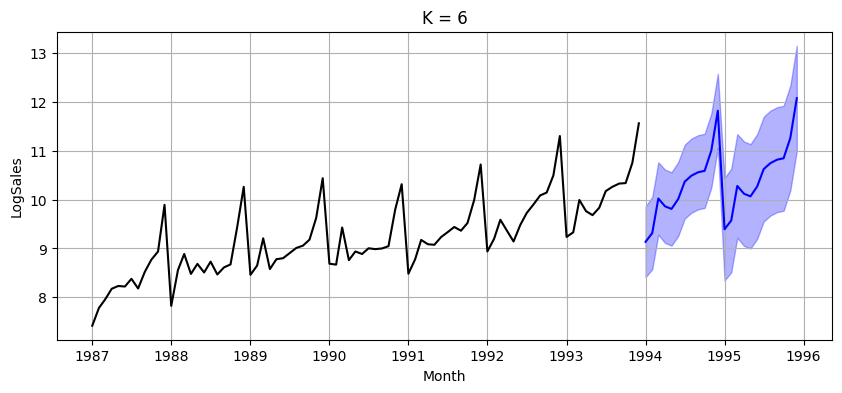

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="Month", y="LogSales", ax=ax, color="k")
sns.lineplot(data=forecast, x="Month", y="LogSales", ax=ax, color="b")
ax.fill_between(forecast["Month"], forecast["lower"], forecast["upper"], color="b", alpha=.3)
ax.set_title(f"K = {6}")
ax.grid(2)

In [44]:
forecast["Sales"] = np.expm1(forecast["LogSales"])

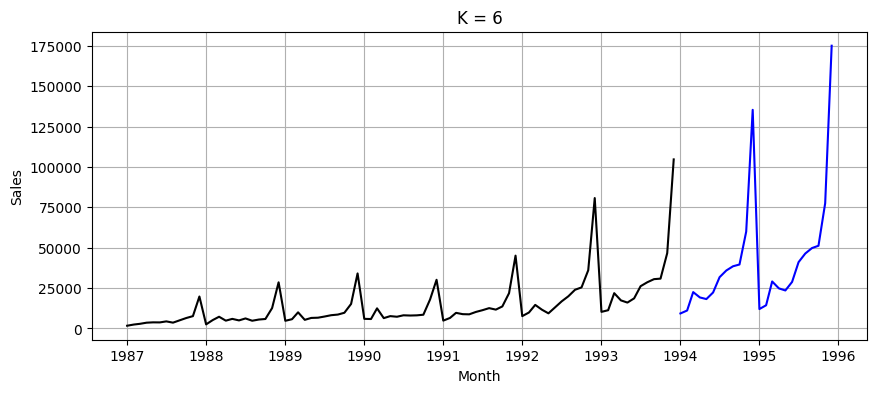

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="Month", y="Sales", ax=ax, color="k")
sns.lineplot(data=forecast, x="Month", y="Sales", ax=ax, color="b")
ax.set_title(f"K = {6}")
ax.grid(2)

##### c) Check the residuals of the fitted model to ensure the ARIMA process has adequately addressed the autocorrelations seen in the TSLM model.

#### 3.0. Repeat the daily electricity example, but instead of using a quadratic function of temperature, use a piecewise linear function with the “knot” around 25 degrees Celsius (use predictors Temperature & Temp2). How can you optimise the choice of knot?

#### 4.0. This exercise concerns aus_accommodation: the total quarterly takings from accommodation and the room occupancy level for hotels, motels, and guest houses in Australia, between January 1998 and June 2016. Total quarterly takings are in millions of Australian dollars.

#### 5.0. We fitted a harmonic regression model to part of the us_gasoline series in Exercise 5 in Section 7.10. We will now revisit this model, and extend it to include more data and ARMA errors.



##### a) Using TSLM(), fit a harmonic regression with a piecewise linear time trend to the full series. Select the position of the knots in the trend and the appropriate number of Fourier terms to include by minimising the AICc or CV value.

##### b) Now refit the model using ARIMA() to allow for correlated errors, keeping the same predictor variables as you used with TSLM().

##### c) Check the residuals of the final model using the gg_tsresiduals() function and a Ljung-Box test. Do they look sufficiently like white noise to continue? If not, try modifying your model, or removing the first few years of data.

##### d) Once you have a model with white noise residuals, produce forecasts for the next year.


#### 6.0. Electricity consumption is often modelled as a function of temperature.

Temperature is measured by daily heating degrees and cooling degrees. Heating degrees is 18∘C minus the average daily temperature when the daily average is below 18∘C; otherwise it is zero. This provides a measure of our need to heat ourselves as temperature falls. Cooling degrees measures our need to cool ourselves as the temperature rises. It is defined as the average daily temperature minus 18∘C when the daily average is above 18∘C; otherwise it is zero. Let $y_t$ denote the monthly total of kilowatt-hours of electricity used, let x1,t denote the monthly total of heating degrees, and let x2,t denote the monthly total of cooling degrees.

An analyst fits the following model to a set of such data:

$y^*_t = \beta_1x^*_{1,t} + \beta_2x^*_{2,t} + \eta_t$

where $(1-\Phi_{1}B^{12} - \Phi_{2}B^{24})(1-B)(1-B^{12})\eta_t = (1+\theta_1 B)\varepsilon_t$

$y_t* = log(y_t), x*_{1,t} = \sqrt{x_{1,t}} and x*_{2,t} = \sqrt{x_2,t}$

##### a). What sort of ARIMA model is identified for $\eta_t$ ?

##### b) The estimated coefficients are:

Explain what the estimates of β1 and β2 tell us about electricity consumption.

##### c) Write the equation in a form more suitable for forecasting.

##### d) Describe how this model could be used to forecast electricity demand for the next 12 months.

##### e) Explain why the $\eta_t$ term should be modelled with an ARIMA model rather than modelling the data using a standard regression package. In your discussion, comment on the properties of the estimates, the validity of the standard regression results, and the importance of the ηt model in producing forecasts.

#### 7. For the retail time series considered in earlier chapters:

##### a) Develop an appropriate dynamic regression model with Fourier terms for the seasonality. Use the AICc to select the number of Fourier terms to include in the model. (You will probably need to use the same Box-Cox transformation you identified previously.)

##### b) Check the residuals of the fitted model. Does the residual series look like white noise?

##### c) Compare the forecasts with those you obtained earlier using alternative models.